# QQ-Plots and Uncorrected VS Corrected 3D Clustering Score
* S18b, S11b
* S18a, S12b, S11a
* S4, S2
* S6, S5, S3

In [55]:
import sys

sys.path.append('../../')
from global_variables import SUBDIR, RUN, WORKSPACE

In [56]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [57]:
def get_cgc_action(gene_action):

    if pd.isnull(gene_action):
        return "Ambiguous"
        
    gene_action = [action.strip() for action in gene_action.split(",")]

    if len(gene_action) == 1:
        if gene_action[0] == "oncogene":
            action = "Oncogene"
        elif gene_action[0] == "TSG":
            action = "Tumour suppressor"
        else:
            action = "Ambiguous"
        
    else:
        if "oncogene" in gene_action and "TSG" in gene_action:
            action = "Ambiguous"
        elif "oncogene" in gene_action:
            action = "Oncogene"
        elif "TSG" in gene_action:
            action = "Tumour suppressor"
        else:
            action = "Ambiguous"
    
    return action


cgc_df = pd.read_csv(f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/input/cancer_202404/CGC_list_v99.tsv", sep = "\t")
cgc_df = cgc_df[["Gene Symbol", "Role in Cancer"]].rename(columns={
    "Gene Symbol" : "Gene", 
    "Role in Cancer" : "Gene_action"})
cgc_df.Gene_action = cgc_df.Gene_action.apply(lambda x: get_cgc_action(x))
cgc_df = cgc_df.assign(Gene=cgc_df['Gene'].str.split(','))
cgc_df = cgc_df.explode('Gene')
cgc_df['Gene'] = cgc_df['Gene'].str.strip()
cgc_df

,Gene,Gene_action
0,A1CF,Oncogene
1,ABI1,Tumour suppressor
2,ABL1,Oncogene
3,ABL2,Oncogene
4,ACKR3,Oncogene
...,...,...
738,ZNF429,Ambiguous
739,ZNF479,Ambiguous
740,ZNF521,Oncogene
741,ZNRF3,Tumour suppressor


# Corrected 3D Clustering Score

In [58]:
def get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=False, rank=False):

    lst_df = []
    n_dict = {}
    for cohort in cohort_df["COHORT"].values:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_genes.csv"
        path_input_mut = f"{maf_input_dir}/{cohort}.in.maf"
        if os.path.exists(path_csv):
            df_o3d = pd.read_csv(path_csv, low_memory=False)
            df_o3d = df_o3d[["Gene", "Uniprot_ID", "Cohort", "pval", "qval", "Score_obs_sim_top_vol", "Mut_in_top_vol", "Mut_in_gene"]].dropna(subset=["pval"]).reset_index(drop=True)
            if rank:
                df_o3d = df_o3d.reset_index().rename(columns={"index": "Rank"})
            
            df_o3d.pval = df_o3d.pval.replace(0, 0.00001)
            df_mut = pd.read_table(path_input_mut, low_memory=False)
            df_mut = df_mut[df_mut["Variant_Classification"] == "Missense_Mutation"].reset_index(drop=True)
            df_mut = df_mut[df_mut.Hugo_Symbol.isin(df_o3d.Gene.unique())]
            
            if min_n != False:
                if len(df_o3d) > min_n:
                    lst_df.append(df_o3d)
            else:
                lst_df.append(df_o3d)
                
            n_dict[cohort] = {}
            n_dict[cohort]["genes"] = len(df_o3d)
            n_dict[cohort]["mut"] = len(df_mut)
        else:
            print(f"Path doesn't exist: {path_csv}")
            
    df = pd.concat(lst_df)
    df["n_genes"] = df.Cohort.map(lambda x: n_dict[x]["genes"])
    df["n_mut"] = df.Cohort.map(lambda x: n_dict[x]["mut"])
    df = df.sort_values(["n_genes", "pval"], ascending=[False, True])

    return df.reset_index(drop=True)

In [59]:
datasets = f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/"
input_path = f"{datasets}/input/cancer_202404"
maf_input_dir = f"{input_path}/maf"
o3d_output_dir = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}"

cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
cohort_df = cohort_df[~cohort_df.COHORT.str.startswith("ICGC")].reset_index(drop=True)

df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir)
df_results = df_results[df_results.Cohort.str.startswith("TCGA")].reset_index(drop=True)
df_results

Path doesn't exist: /data/bbg/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


,Gene,Uniprot_ID,Cohort,pval,qval,Score_obs_sim_top_vol,Mut_in_top_vol,Mut_in_gene,n_genes,n_mut
0,BRAF,P15056,TCGA_WXS_MEL,0.00001,0.0,154.374330,245.0,269,10058,165420
1,NRAS,P01111,TCGA_WXS_MEL,0.00001,0.0,57.088760,126.0,127,10058,165420
2,MAP2K1,A4QPA9,TCGA_WXS_MEL,0.00001,0.0,8.864405,20.0,27,10058,165420
3,CNOT9,D5MQE1,TCGA_WXS_MEL,0.00001,0.0,7.687517,14.0,15,10058,165420
4,RAC1,A4D2P1,TCGA_WXS_MEL,0.00001,0.0,7.117122,18.0,22,10058,165420
...,...,...,...,...,...,...,...,...,...,...
36091,UBE3C,Q15386,TCGA_WXS_CHRCC,0.04960,1.0,1.719813,2.0,2,7,28
36092,ATP6V0A4,A0A024R791,TCGA_WXS_CHRCC,0.05770,1.0,1.685607,2.0,2,7,28
36093,CREG2,Q8IUH2,TCGA_WXS_CHRCC,0.08770,1.0,1.592002,2.0,2,7,28
36094,GAL3ST3,Q96A11,TCGA_WXS_CHRCC,0.11200,1.0,1.508403,2.0,2,7,28


## S18b, S12b: QQ-pltos and MLFC 

In [60]:
def qq_plot(
    df_results, 
    title=None, 
    filename=None, 
    figsize=(10, 16), 
    tcga=True, 
    title_fontsize=12, 
    cols=4,
    cgc_df=None,
    low_cut=True,
    thr_low=0.1,
    target_low="qval",
    high_cut=False,
    thr_high=1,
    target_high="pval",
    absolute=True,
    letter=False
    ):
    
    rows = math.ceil(len(df_results.Cohort.unique()) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()
    
    if letter:
        fig.text(
            -0.01,         
            1.03,         
            letter,
            transform=fig.transFigure,
            fontsize=32,   
            fontweight='bold',
            va='top',   
            ha='left'    
        )

    cmap = plt.cm.rainbow  # Using the rainbow colormap

    for i, (cohort, df) in enumerate(df_results.groupby("Cohort", sort=False)):

        # Compute observed p-values and theoretical quantiles
        pvals = -np.log10(df.pval.values)
        n = len(pvals)
        expected = -np.log10(np.linspace(1/n, 1, n))
        ax = axes[i]
        
        # Normalize colors and sizes based on Mut_in_gene
        norm = plt.Normalize(df["Mut_in_gene"].min(), df["Mut_in_gene"].max())
        size_scale = (df["Mut_in_gene"] - df["Mut_in_gene"].min()) / (df["Mut_in_gene"].max() - df["Mut_in_gene"].min())
        marker_sizes = 10 + (size_scale * 100)  # Scale marker sizes between 10 and 100

        # Scatter plot with size and color based on "Mut_in_gene"
        ax.scatter(expected, pvals, c=df["Mut_in_gene"], cmap=cmap, norm=norm, s=marker_sizes, alpha=0.6, lw=0)
        
        # Expected line (y=x)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x, color='black', linestyle='--', label='Expected Line (y=x)')

        # MLFC
        df_filtered = filter(df, cgc_df=cgc_df, thr_low=thr_low, thr_high=thr_high, target_low=target_low, target_high=target_high, low_cut=low_cut, high_cut=high_cut)
        score = mlfc(df_filtered.pval.values, absolute) 

        # Add labels and title for each subplot
        cohort = cohort.replace("TCGA_WXS_SOFT_TISSUE", "TCGA_WXS_SARC")
        cohort_name = cohort.split("_")[-1] if tcga else cohort
        ax.set_title(f'{cohort_name}\n# genes = {df["n_genes"].unique()[0]}\n# mut = {df["n_mut"].unique()[0]}\nMLFC = {score:.3f}', fontsize=title_fontsize)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
    
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Add color bar next to each subplot
        fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', 
                            fraction=1, pad=0.04)
        # cbar.set_label("Mutations in Gene")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.supxlabel("Theoretical quantiles\n-log10(p-values)")
    fig.supylabel("Observed quantiles\n-log10(p-values)")
    if title:
        plt.suptitle(title, fontsize=14, y=1.02)

    if filename:
        plt.savefig(filename, dpi=900, bbox_inches='tight')
    plt.show()


def filter(
    df, 
    cgc_df=None, 
    low_cut=True, 
    thr_low=0.1, 
    target_low="qval", 
    high_cut=False, 
    thr_high=1, 
    target_high="pval"):

    if cgc_df is not None:
        df = df[~df["Gene"].isin(cgc_df.Gene)]
    if low_cut:
        df = df[df[target_low] >= thr_low].reset_index(drop=True)
    if high_cut:
        df = df[df[target_high] < thr_high].reset_index(drop=True)

    return df


def mlfc(pvals, absolute): 
    """
    mean absolute log2 fold change (MLFC) quantify the 
    differences between the observed P values and those 
    expected from a uniform distribution.

    If absolute = True, a general deviation from the uniform
    distribution is computed. If absolute = False, a positive 
    score indicate an overestimation of pvalues (p-values are 
    larger than expected), while a negative score indicate an 
    underestimation (p-values are lower than expected.)
    """

    pvals = np.sort(pvals)
    n = len(pvals)
    expected = np.linspace(min(pvals), max(pvals), n)
    if absolute:
        score = sum(abs(np.log2((pvals / expected)))) / n 
    else:
        score = sum(np.log2((pvals / expected))) / n 

    return score

Path doesn't exist: /data/bbg/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


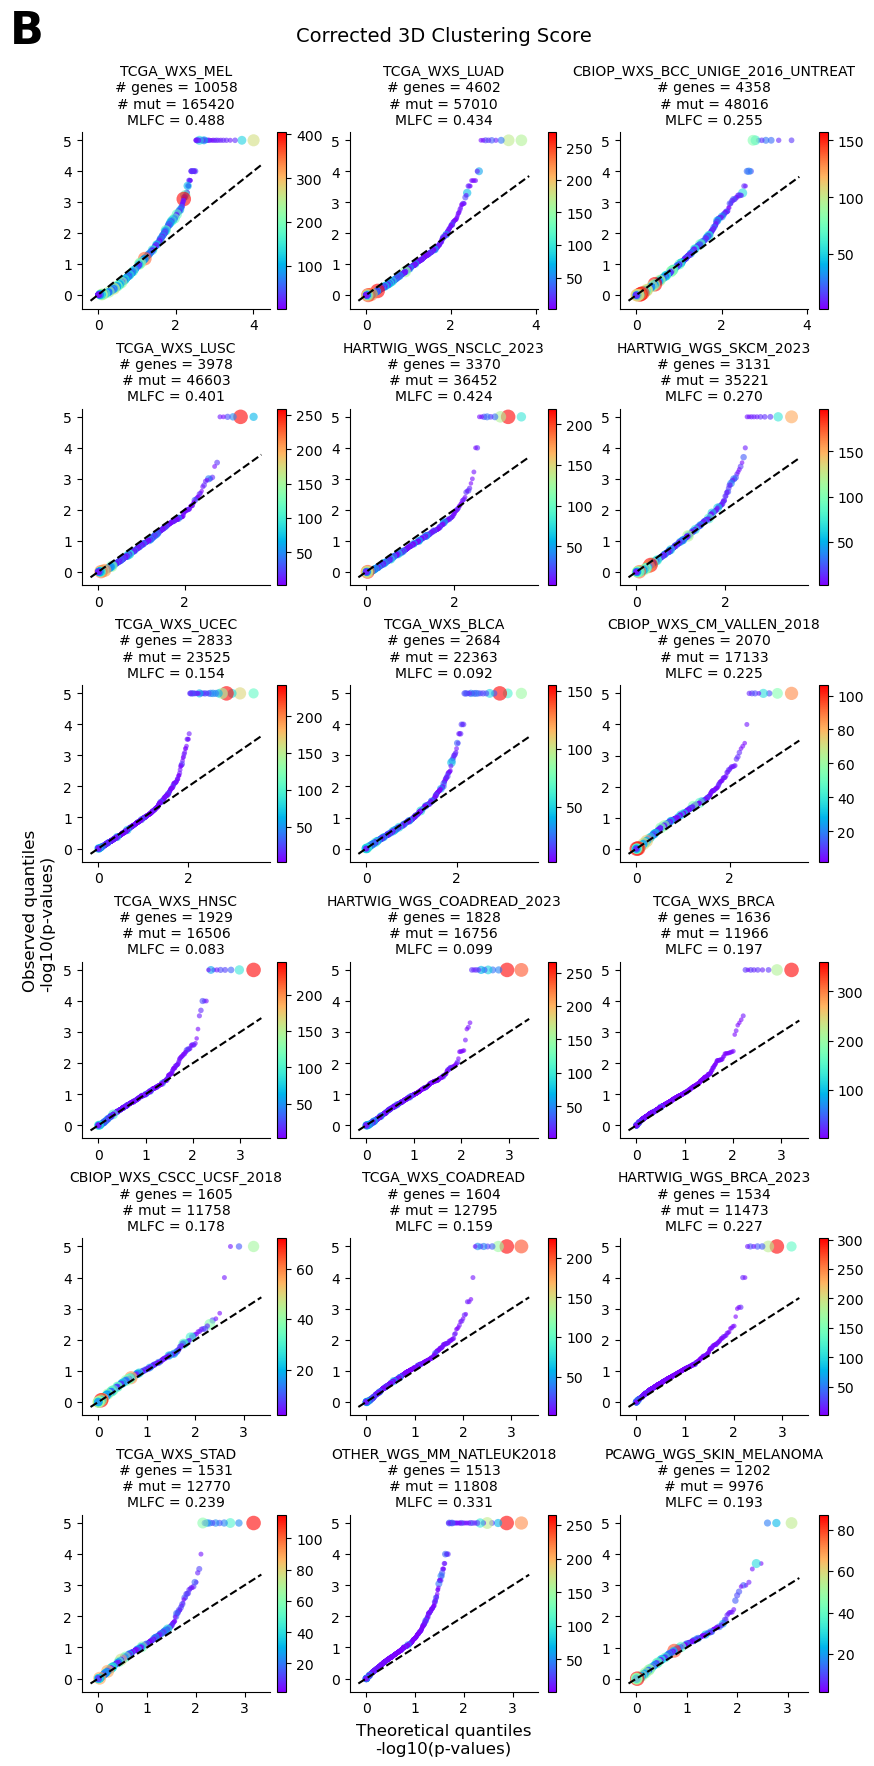

In [61]:
df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=1200) 

qq_plot(
    df_results, 
    title="Corrected 3D Clustering Score", 
    filename="plots/qqplots_norm_abs.png",
    figsize=(8.5, 17), 
    tcga=False, 
    title_fontsize=10, 
    cols=3,
    cgc_df=cgc_df,
    low_cut=True,
    thr_low=0.1,
    target_low="qval",
    high_cut=False,
    absolute=True,
    letter="B"
    )

# qq_plot(
#     df_results, 
#     title="Corrected 3D Clustering Score", 
#     filename="plots/qqplots_norm_signed.png",
#    figsize=(8.5, 17), 
#     tcga=False, 
#     title_fontsize=10, 
#     cols=3,
#     cgc_df=cgc_df,
#     low_cut=True,
#     thr_low=0.1,
#     target_low="qval",
#     high_cut=False,
#     absolute=False
#     )

In [62]:
from tqdm import tqdm

cgc_df=cgc_df
low_cut=True
thr_low=0.1,
target_low="qval"
high_cut=False

result = []
df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir) 
df_filtered = filter(df_results, cgc_df=cgc_df, thr_low=thr_low, high_cut=high_cut)
absolute=True
score = mlfc(pvals=df_filtered.pval.values, absolute=absolute) 
result.append({"Cohort": "All", "Score": score, "N_pvals": len(df_filtered), "Abs": absolute})
absolute=False
score = mlfc(pvals=df_filtered.pval.values, absolute=absolute) 
result.append({"Cohort": "All", "Score": score, "N_pvals": len(df_filtered), "Abs": absolute})

for cohort in tqdm(df_filtered.Cohort.unique()):
    df_filtered_cohort = df_filtered[df_filtered["Cohort"] == cohort].reset_index(drop=True)
    absolute=True
    score = mlfc(pvals=df_filtered_cohort.pval.values, absolute=absolute) 
    result.append({"Cohort": cohort, "Score": score, "N_pvals": len(df_filtered_cohort), "Abs": absolute})
    absolute=False
    score = mlfc(pvals=df_filtered_cohort.pval.values, absolute=absolute) 
    result.append({"Cohort": cohort, "Score": score, "N_pvals": len(df_filtered_cohort), "Abs": absolute})

result = pd.DataFrame(result)
display(result)
display(result[result["Cohort"] != "All"].groupby("Abs").median())

Path doesn't exist: /data/bbg/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


100%|██████████| 190/190 [00:00<00:00, 334.61it/s]


,Cohort,Score,N_pvals,Abs
0,All,0.273339,65599,True
1,All,-0.206001,65599,False
2,TCGA_WXS_MEL,0.488179,9567,True
3,TCGA_WXS_MEL,0.460484,9567,False
4,TCGA_WXS_LUAD,0.433865,4355,True
...,...,...,...,...
377,PEDCBIOP_WXS_NBL_PRY,0.000000,1,False
378,CBIOP_WXS_BRCA_MBCP_PRY_TREAT_2020,0.000000,1,True
379,CBIOP_WXS_BRCA_MBCP_PRY_TREAT_2020,0.000000,1,False
380,PEDCBIOP_WXS_RB_PRY,0.000000,1,True


,Score,N_pvals
Abs,,
False,-0.793769,32.0
True,0.794788,32.0


Path doesn't exist: /data/bbg/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


100%|██████████| 190/190 [00:00<00:00, 334.86it/s]


,Cohort,Score,N_pvals,Abs
0,TCGA_WXS_MEL,0.488179,9567,True
1,TCGA_WXS_LUAD,0.433865,4355,True
2,CBIOP_WXS_BCC_UNIGE_2016_UNTREAT,0.255260,4143,True
3,TCGA_WXS_LUSC,0.400759,3763,True
4,HARTWIG_WGS_NSCLC_2023,0.424044,3167,True
5,HARTWIG_WGS_SKCM_2023,0.269648,2979,True
6,TCGA_WXS_UCEC,0.154466,2620,True
7,TCGA_WXS_BLCA,0.092204,2453,True
8,CBIOP_WXS_CM_VALLEN_2018,0.225397,1953,True
9,TCGA_WXS_HNSC,0.083415,1803,True


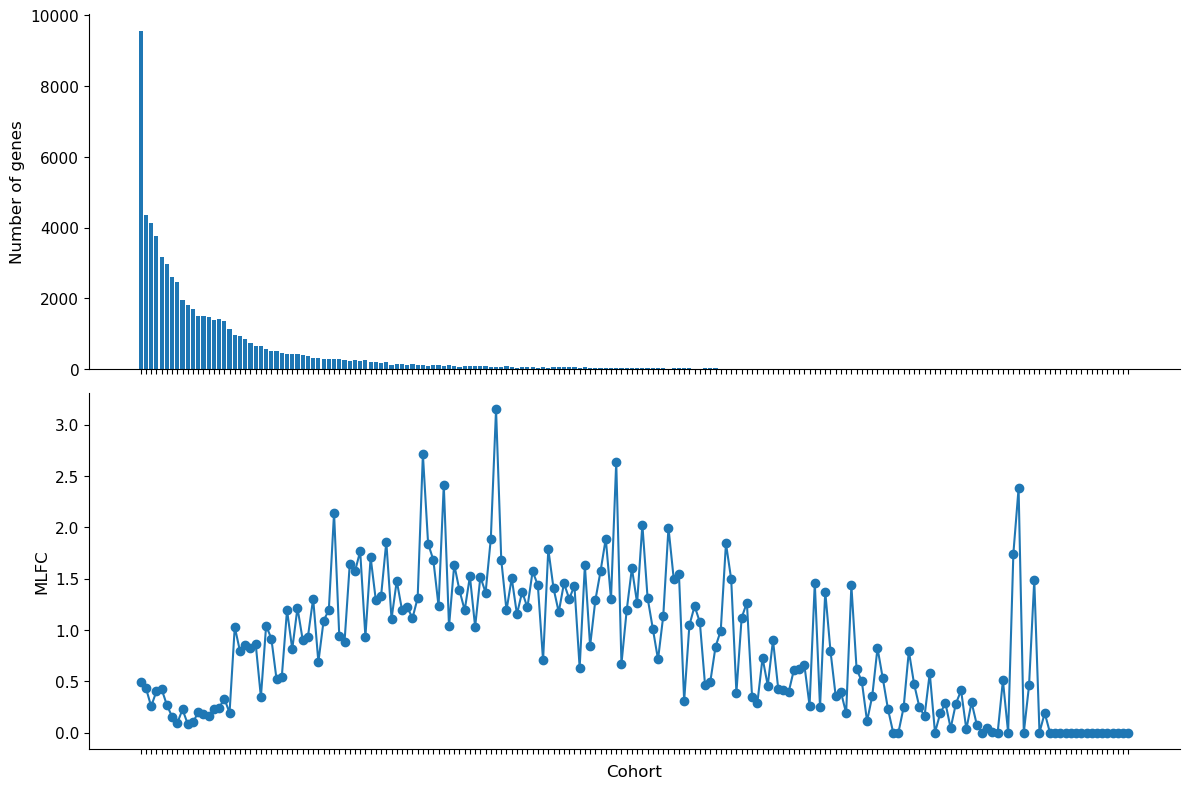

In [63]:
from tqdm import tqdm

cgc_df=cgc_df
low_cut=True
thr_low=0.1,
target_low="qval"
high_cut=False

result = []
df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir) 
df_filtered = filter(df_results, cgc_df=cgc_df, thr_low=thr_low, high_cut=high_cut)

for cohort in tqdm(df_filtered.Cohort.unique()):
    df_filtered_cohort = df_filtered[df_filtered["Cohort"] == cohort].reset_index(drop=True)
    absolute=True
    score = mlfc(pvals=df_filtered_cohort.pval.values, absolute=absolute) 
    result.append({"Cohort": cohort, "Score": score, "N_pvals": len(df_filtered_cohort), "Abs": absolute})

result = pd.DataFrame(result)
display(result[:20])


# Plot MLFC
show_labels = False
df = result

# Prepare data for plotting
unique_cohorts = df['Cohort'].unique()
x = np.arange(len(unique_cohorts))

# Bar values: take N_pvals where Abs is True
bar_values = df[df['Abs']].drop_duplicates('Cohort').set_index('Cohort')['N_pvals'].reindex(unique_cohorts)

# Line values: pivot scores by Abs
line_df = df.pivot(index='Cohort', columns='Abs', values='Score').reindex(unique_cohorts)

# Create figure with two rows
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))


# Top: bar chart of number of p-values
ax1.bar(x, bar_values)
ax1.set_ylabel('Number of genes', fontsize=12)

# Bottom: line plot of scores
ax2.plot(x, line_df[True], marker='o')
ax2.set_ylabel('MLFC', fontsize=12)
ax2.set_xlabel('Cohort', fontsize=12)
ax1.tick_params(axis='y', labelsize=11)
ax2.tick_params(axis='y', labelsize=11)

# X-axis labeling
ax2.set_xticks(x)
if show_labels:
    ax2.set_xticklabels(unique_cohorts, rotation=45, ha='right')
else:
    ax2.set_xticklabels([])

for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("plots/mlfc_norm.png", dpi=900, bbox_inches='tight')
plt.show()

## S11a: Associations between number of mutations in the gene (N) with p-value and 3D clustering score

Path doesn't exist: /data/bbg/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


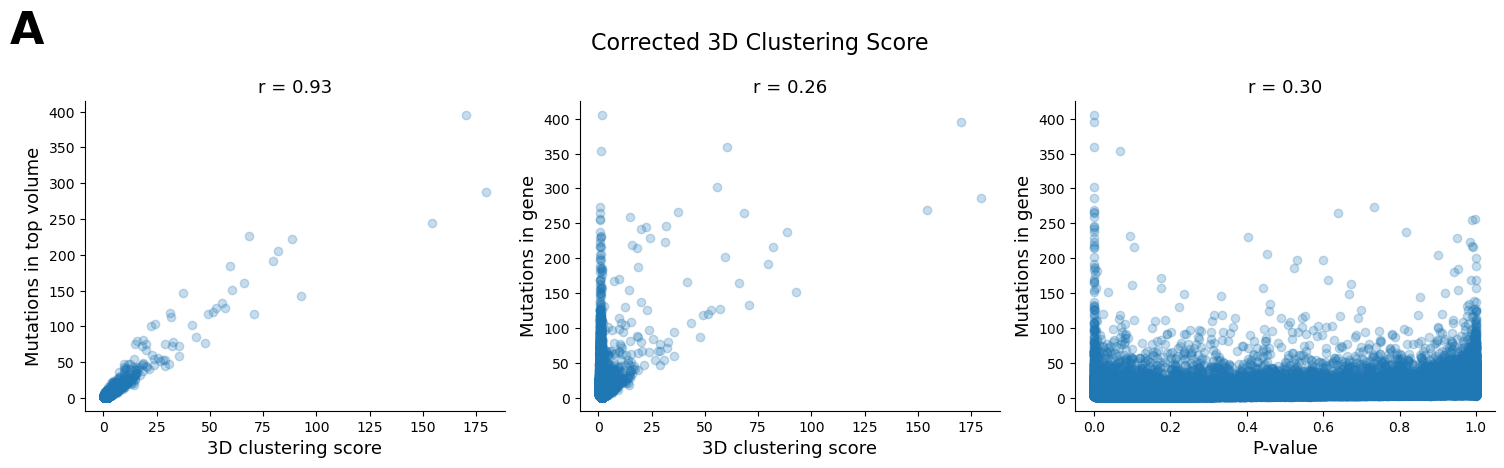

In [64]:
# Associations between N (number of mutations in the gene) and p-value or 3D score

df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir)

n_cohorts = len(df_results.Cohort.unique()) # 203 out of 215 cohorts have at least one processed gene
n_genes = len(df_results.Gene.unique())
n_volumes = len(df_results)

fig, axs = plt.subplots(1, 3, figsize=(15, 4.5))
axs = axs.flatten()  

fig.text(
    0,         
    1.03,         
    "A",
    transform=fig.transFigure,
    fontsize=32,   
    fontweight='bold',
    va='top',   
    ha='left'    
)

# Plot 3D score vs Mut_in_top_vol
axs[0].scatter(df_results["Score_obs_sim_top_vol"], df_results["Mut_in_top_vol"], alpha=0.25)
axs[0].set_xlabel("3D clustering score", fontsize=13)
axs[0].set_ylabel("Mutations in top volume", fontsize=13)
axs[0].set_title(f'r = {df_results["Score_obs_sim_top_vol"].corr(df_results["Mut_in_top_vol"]):.2f}', fontsize=13)

# Plot 3D score vs Mut_in_gene
axs[1].scatter(df_results["Score_obs_sim_top_vol"], df_results["Mut_in_gene"], alpha=0.25)
axs[1].set_xlabel("3D clustering score", fontsize=13)
axs[1].set_ylabel("Mutations in gene", fontsize=13)
axs[1].set_title(f'r = {df_results["Score_obs_sim_top_vol"].corr(df_results["Mut_in_gene"]):.2f}', fontsize=13)

# Plot P-value vs Mut_in_gene
axs[2].scatter(df_results["pval"], df_results["Mut_in_gene"], alpha=0.25)
axs[2].set_xlabel("P-value", fontsize=13)
axs[2].set_ylabel("Mutations in gene", fontsize=13)
axs[2].set_title(f'r = {df_results["pval"].corr(df_results["Mut_in_gene"]):.2f}', fontsize=13)


fig.suptitle("Corrected 3D Clustering Score", fontsize=16)

for ax in range(3):
    axs[ax].spines['top'].set_visible(False)
    axs[ax].spines['right'].set_visible(False)

fig.tight_layout(rect=[0, 0, 1, 0.994])
plt.savefig("plots/score_norm_correlation.png", dpi=900, bbox_inches='tight')
plt.show()


In [65]:
# Detected genes and score distribution
df_results_norm = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=False)
df_results_norm = df_results_norm[df_results_norm["qval"] < 0.01]
print("Detected gene-cancer:", len(df_results_norm))
print("Detected gene:", len(df_results_norm.Gene.unique()))

Path doesn't exist: /data/bbg/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv
Detected gene-cancer: 619
Detected gene: 273


# Uncorrected 3D Clustering Score

In [66]:
SUBDIR = "review"
RUN = "run_notnorm_2025-03-26_10-58-45"

In [67]:
datasets = f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/"
input_path = f"{datasets}/input/cancer_202404"
maf_input_dir = f"{input_path}/maf"
o3d_output_dir = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}"

cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
cohort_df = cohort_df[~cohort_df.COHORT.str.startswith("ICGC")].reset_index(drop=True)

df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir)
df_results = df_results[df_results.Cohort.str.startswith("TCGA")].reset_index(drop=True)
df_results

Path doesn't exist: /data/bbg/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/review/run_notnorm_2025-03-26_10-58-45/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


,Gene,Uniprot_ID,Cohort,pval,qval,Score_obs_sim_top_vol,Mut_in_top_vol,Mut_in_gene,n_genes,n_mut
0,BRAF,P15056,TCGA_WXS_MEL,0.00001,0.0,161.396484,243.0,269,10058,165420
1,NRAS,P01111,TCGA_WXS_MEL,0.00001,0.0,66.875076,122.0,127,10058,165420
2,MAP2K1,A4QPA9,TCGA_WXS_MEL,0.00001,0.0,8.509448,20.0,27,10058,165420
3,RAC1,A4D2P1,TCGA_WXS_MEL,0.00001,0.0,8.464008,18.0,22,10058,165420
4,CNOT9,D5MQE1,TCGA_WXS_MEL,0.00001,0.0,7.297280,14.0,15,10058,165420
...,...,...,...,...,...,...,...,...,...,...
36089,SCAPER,Q9BY12,TCGA_WXS_CHRCC,0.01930,1.0,1.491021,2.0,2,7,28
36090,UBE3C,Q15386,TCGA_WXS_CHRCC,0.04940,1.0,1.517692,2.0,2,7,28
36091,ATP6V0A4,A0A024R791,TCGA_WXS_CHRCC,0.05770,1.0,1.371249,2.0,2,7,28
36092,CREG2,Q8IUH2,TCGA_WXS_CHRCC,0.08770,1.0,1.188918,2.0,2,7,28


## S18a: QQ-Plots and MLFC

Path doesn't exist: /data/bbg/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/review/run_notnorm_2025-03-26_10-58-45/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


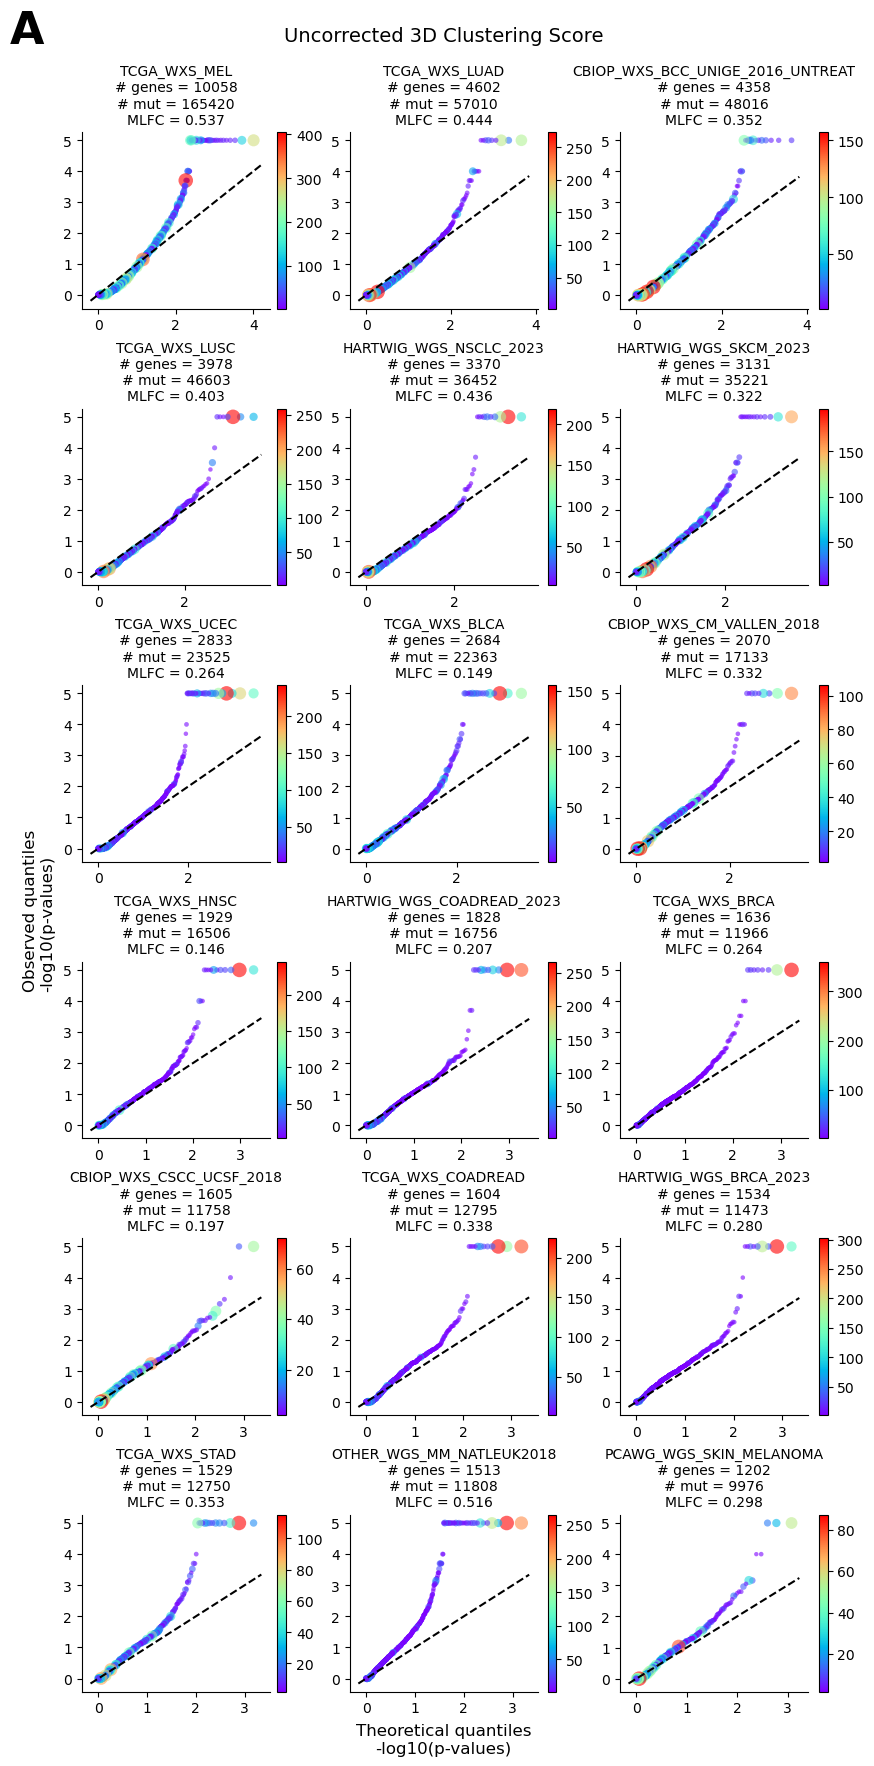

In [68]:
df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=1200) 

qq_plot(
    df_results, 
    title="Uncorrected 3D Clustering Score", 
    filename="plots/qqplots_notnorm_abs.png",
    figsize=(8.5, 17), 
    tcga=False, 
    title_fontsize=10, 
    cols=3,
    cgc_df=cgc_df,
    low_cut=True,
    thr_low=0.1,
    target_low="qval",
    high_cut=False,
    absolute=True,
    letter="A"
    )

# qq_plot(
#     df_results, 
#     title="Uncorrected 3D Clustering Score", 
#     filename="plots/qqplots_notnorm_signed.png",
#    figsize=(8.5, 17), 
#     tcga=False, 
#     title_fontsize=10, 
#     cols=3,
#     cgc_df=cgc_df,
#     low_cut=True,
#     thr_low=0.1,
#     target_low="qval",
#     high_cut=False,
#     absolute=False
#     )

In [69]:
from tqdm import tqdm

cgc_df=cgc_df
low_cut=True
thr_low=0.1,
target_low="qval"
high_cut=False

result = []
df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir) 
df_filtered = filter(df_results, cgc_df=cgc_df, thr_low=thr_low, high_cut=high_cut)
absolute=True
score = mlfc(pvals=df_filtered.pval.values, absolute=absolute) 
result.append({"Cohort": "All", "Score": score, "N_pvals": len(df_filtered), "Abs": absolute})
absolute=False
score = mlfc(pvals=df_filtered.pval.values, absolute=absolute) 
result.append({"Cohort": "All", "Score": score, "N_pvals": len(df_filtered), "Abs": absolute})

for cohort in tqdm(df_filtered.Cohort.unique()):
    df_filtered_cohort = df_filtered[df_filtered["Cohort"] == cohort].reset_index(drop=True)
    absolute=True
    score = mlfc(pvals=df_filtered_cohort.pval.values, absolute=absolute) 
    result.append({"Cohort": cohort, "Score": score, "N_pvals": len(df_filtered_cohort), "Abs": absolute})
    absolute=False
    score = mlfc(pvals=df_filtered_cohort.pval.values, absolute=absolute) 
    result.append({"Cohort": cohort, "Score": score, "N_pvals": len(df_filtered_cohort), "Abs": absolute})

result = pd.DataFrame(result)
display(result)
display(result[result["Cohort"] != "All"].groupby("Abs").median())

Path doesn't exist: /data/bbg/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/review/run_notnorm_2025-03-26_10-58-45/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


100%|██████████| 190/190 [00:00<00:00, 333.40it/s]


,Cohort,Score,N_pvals,Abs
0,All,0.425483,65443,True
1,All,-0.260952,65443,False
2,TCGA_WXS_MEL,0.536918,9558,True
3,TCGA_WXS_MEL,0.492348,9558,False
4,TCGA_WXS_LUAD,0.444034,4355,True
...,...,...,...,...
377,PEDCBIOP_WXS_NBL_PRY,0.000000,1,False
378,CBIOP_WXS_BRCA_MBCP_PRY_TREAT_2020,0.000000,1,True
379,CBIOP_WXS_BRCA_MBCP_PRY_TREAT_2020,0.000000,1,False
380,PEDCBIOP_WXS_RB_PRY,0.000000,1,True


,Score,N_pvals
Abs,,
False,-1.118196,31.5
True,1.121629,31.5


Path doesn't exist: /data/bbg/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/review/run_notnorm_2025-03-26_10-58-45/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


100%|██████████| 190/190 [00:00<00:00, 336.40it/s]


,Cohort,Score,N_pvals,Abs
0,TCGA_WXS_MEL,0.536918,9558,True
1,TCGA_WXS_LUAD,0.444034,4355,True
2,CBIOP_WXS_BCC_UNIGE_2016_UNTREAT,0.352346,4135,True
3,TCGA_WXS_LUSC,0.403452,3762,True
4,HARTWIG_WGS_NSCLC_2023,0.435610,3167,True
5,HARTWIG_WGS_SKCM_2023,0.321689,2978,True
6,TCGA_WXS_UCEC,0.263620,2617,True
7,TCGA_WXS_BLCA,0.149102,2454,True
8,CBIOP_WXS_CM_VALLEN_2018,0.331559,1948,True
9,TCGA_WXS_HNSC,0.145874,1803,True


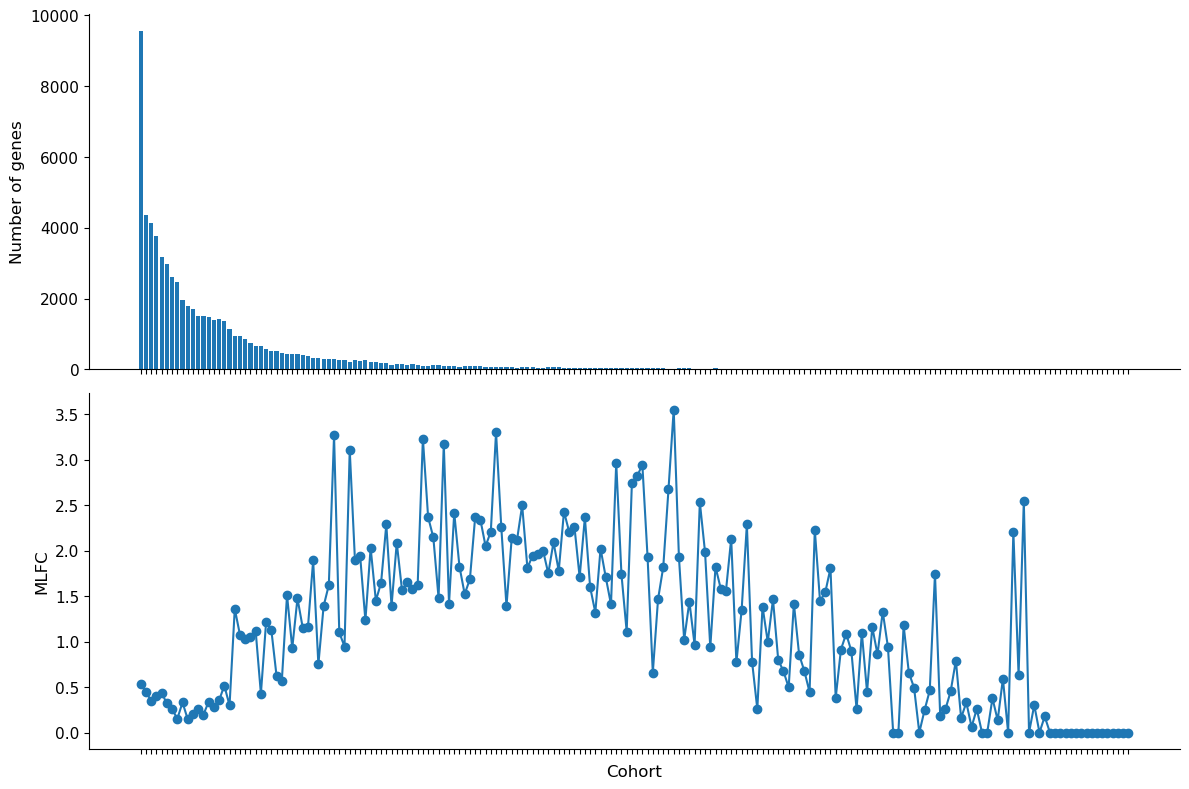

In [70]:
from tqdm import tqdm

cgc_df=cgc_df
low_cut=True
thr_low=0.1,
target_low="qval"
high_cut=False

result = []
df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir) 
df_filtered = filter(df_results, cgc_df=cgc_df, thr_low=thr_low, high_cut=high_cut)

for cohort in tqdm(df_filtered.Cohort.unique()):
    df_filtered_cohort = df_filtered[df_filtered["Cohort"] == cohort].reset_index(drop=True)
    absolute=True
    score = mlfc(pvals=df_filtered_cohort.pval.values, absolute=absolute) 
    result.append({"Cohort": cohort, "Score": score, "N_pvals": len(df_filtered_cohort), "Abs": absolute})

result = pd.DataFrame(result)
display(result[:20])


# Plot MLFC
show_labels = False
df = result

# Prepare data for plotting
unique_cohorts = df['Cohort'].unique()
x = np.arange(len(unique_cohorts))

# Bar values: take N_pvals where Abs is True
bar_values = df[df['Abs']].drop_duplicates('Cohort').set_index('Cohort')['N_pvals'].reindex(unique_cohorts)

# Line values: pivot scores by Abs
line_df = df.pivot(index='Cohort', columns='Abs', values='Score').reindex(unique_cohorts)

# Create figure with two rows
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))


# Top: bar chart of number of p-values
ax1.bar(x, bar_values)
ax1.set_ylabel('Number of genes', fontsize=12)

# Bottom: line plot of scores
ax2.plot(x, line_df[True], marker='o')
ax2.set_ylabel('MLFC', fontsize=12)
ax2.set_xlabel('Cohort', fontsize=12)
ax1.tick_params(axis='y', labelsize=11)
ax2.tick_params(axis='y', labelsize=11)

# X-axis labeling
ax2.set_xticks(x)
if show_labels:
    ax2.set_xticklabels(unique_cohorts, rotation=45, ha='right')
else:
    ax2.set_xticklabels([])

for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("plots/mlfc_notnorm.png", dpi=600, bbox_inches='tight')
plt.show()

## S11b: Associations between number of mutations in the gene (N) with p-value and 3D clustering score

Path doesn't exist: /data/bbg/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/review/run_notnorm_2025-03-26_10-58-45/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


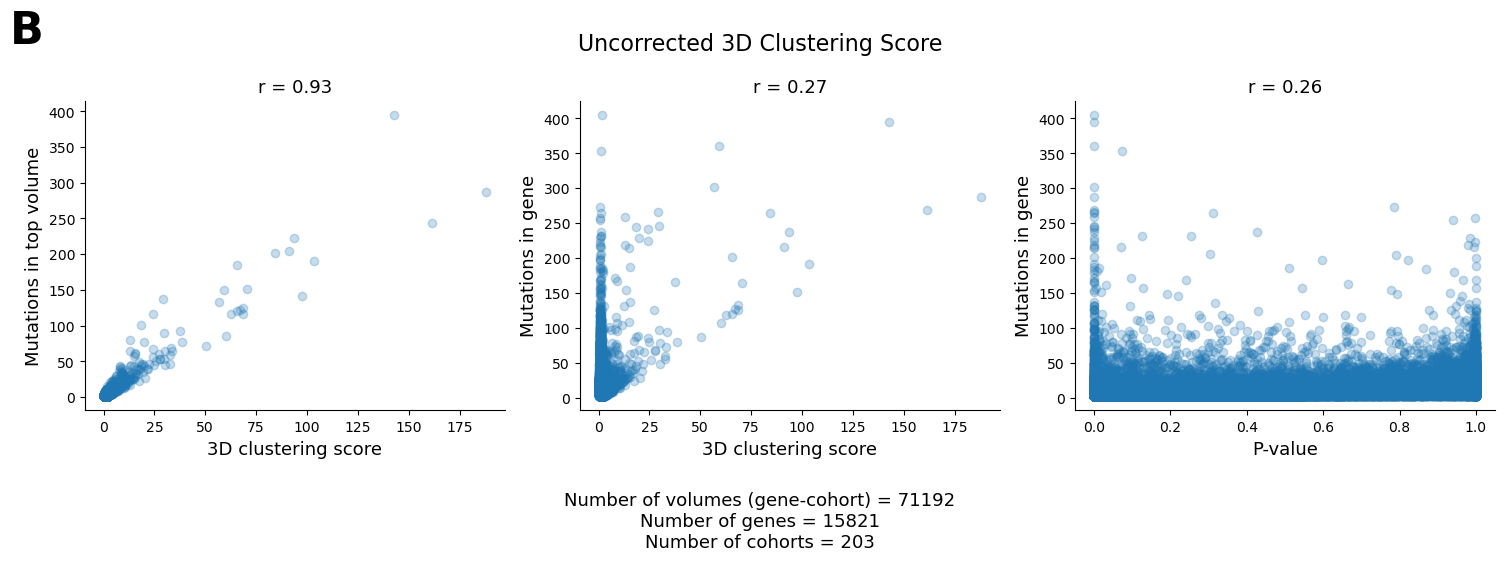

In [71]:
# Associations between N (number of mutations in the gene) and p-value or 3D score

df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir)

n_cohorts = len(df_results.Cohort.unique()) 
n_genes = len(df_results.Gene.unique())
n_volumes = len(df_results)

fig, axs = plt.subplots(1, 3, figsize=(15, 4.5))
axs = axs.flatten()  

fig.text(
    0,         
    1.03,         
    "B",
    transform=fig.transFigure,
    fontsize=32,   
    fontweight='bold',
    va='top',   
    ha='left'    
)

# Plot 3D score vs Mut_in_top_vol
axs[0].scatter(df_results["Score_obs_sim_top_vol"], df_results["Mut_in_top_vol"], alpha=0.25)
axs[0].set_xlabel("3D clustering score", fontsize=13)
axs[0].set_ylabel("Mutations in top volume", fontsize=13)
axs[0].set_title(f'r = {df_results["Score_obs_sim_top_vol"].corr(df_results["Mut_in_top_vol"]):.2f}', fontsize=13)

# Plot 3D score vs Mut_in_gene
axs[1].scatter(df_results["Score_obs_sim_top_vol"], df_results["Mut_in_gene"], alpha=0.25)
axs[1].set_xlabel("3D clustering score", fontsize=13)
axs[1].set_ylabel("Mutations in gene", fontsize=13)
axs[1].set_title(f'r = {df_results["Score_obs_sim_top_vol"].corr(df_results["Mut_in_gene"]):.2f}', fontsize=13)

# Plot P-value vs Mut_in_gene
axs[2].scatter(df_results["pval"], df_results["Mut_in_gene"], alpha=0.25)
axs[2].set_xlabel("P-value", fontsize=13)
axs[2].set_ylabel("Mutations in gene", fontsize=13)
axs[2].set_title(f'r = {df_results["pval"].corr(df_results["Mut_in_gene"]):.2f}', fontsize=13)


fig.suptitle("Uncorrected 3D Clustering Score", fontsize=16)
fig.text(0.5, -0.165,
        f"Number of volumes (gene-cohort) = {n_volumes}\n"
        f"Number of genes = {n_genes}\n"
        f"Number of cohorts = {n_cohorts}",
        fontsize=13, ha='center')

for ax in range(3):
    axs[ax].spines['top'].set_visible(False)
    axs[ax].spines['right'].set_visible(False)

fig.tight_layout(rect=[0, 0, 1, 0.994])
plt.savefig("plots/score_notnorm_correlation.png", dpi=900, bbox_inches='tight')
plt.show()

In [72]:
# Detected genes and score distribution
df_results_notnorm = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=False)
df_results_notnorm = df_results_notnorm[df_results_notnorm["qval"] < 0.01]
print("Detected gene-cancer:", len(df_results_notnorm))
print("Detected gene:", len(df_results_notnorm.Gene.unique()))

Path doesn't exist: /data/bbg/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/review/run_notnorm_2025-03-26_10-58-45/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv
Detected gene-cancer: 740
Detected gene: 363


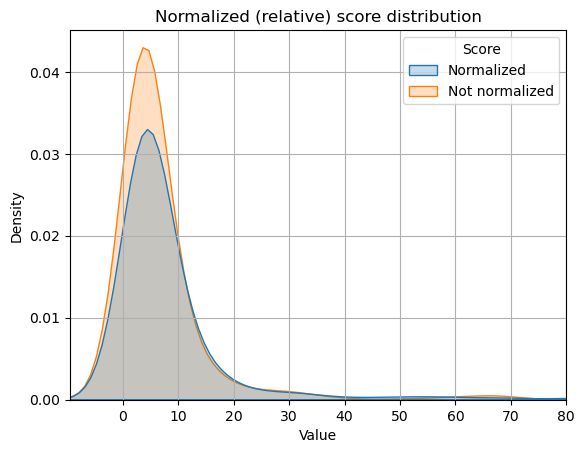

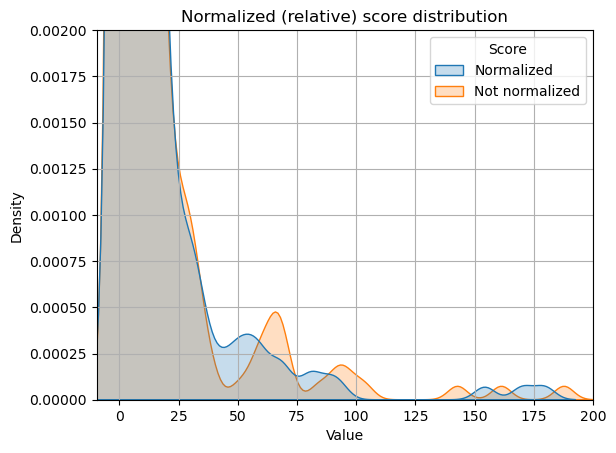

In [73]:
# Score distribution

df_results_norm["Score"] = "Normalized"
df_results_notnorm["Score"] = "Not normalized"
df_results_plot = pd.concat((df_results_norm[["Score", "Score_obs_sim_top_vol"]], df_results_notnorm[["Score", "Score_obs_sim_top_vol"]]))

sns.kdeplot(data = df_results_plot, x="Score_obs_sim_top_vol", fill=True, hue="Score")
plt.title("Normalized (relative) score distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.xlim(-9.5, 80)
plt.grid(True)
plt.show()

sns.kdeplot(data = df_results_plot, x="Score_obs_sim_top_vol", fill=True, hue="Score")
plt.title("Normalized (relative) score distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.xlim(-9.5, 200)
plt.ylim(0, 0.002)
plt.grid(True)
plt.show()

## S4 and S2: Plot functions as curves

In [74]:
from functools import reduce
import operator
from decimal import Decimal, getcontext
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


def dcm_factorial(n):
    """
    Compute factorial.
    """
    return reduce(operator.mul, [Decimal(i) for i in range(1, int(n)+1)], Decimal(1))


def dcm_binom_coeff(n, k):
    """
    Compute binomial coefficient.
    """
    
    return dcm_factorial(n) / (dcm_factorial(k) * dcm_factorial(n - k))


def dcm_binom_cdf(k, n, p):
    """
    Compute binomial cumulative distribution function (CDF).
    """
    
    p = Decimal(p)
    q = Decimal(1) - p
    cdf = Decimal(0)
    for i in range(int(k) + 1):
        cdf += dcm_binom_coeff(n, i) * (p ** i) * (q ** (n - i))
        
    return cdf


def dcm_binom_sf(k, n, p):
    """
    Compute binomial survival function (SF).
    """
    
    return Decimal('1') - dcm_binom_cdf(k, n, p)


def dcm_binom_logsf(k, n, p):
    """
    Compute log binomial survival function.
    """
    
    sf = dcm_binom_sf(k, n, p)
    if sf <= 0:
        return np.inf
    return sf.ln()


def get_dcm_anomaly_score(k, n, p, decimal=600):          
    """
    Use the decimal package to compute the anomaly score 
    with high precision to avoid approximation of the 
    numerator.
    
    Score: loglik equal or larger mut_count / loglik(N)
    """

    getcontext().prec = decimal
    num = dcm_binom_logsf(k-1, n, p)
    den = stats.binom.logpmf(k=n, n=n, p=p)

    return float(num / Decimal(den))


def get_anomaly_score(vec_mut_in_vol, gene_mut, vec_vol_miss_mut_prob):          
    """
    Compute a metric that scores the anomaly of observing a certain 
    number of mutations in the volume of a residue.
    It takes into account the volume and the mutation rate of the codon 
    of each residue within that volume.
    
    Score: loglik equal or larger mut_count / loglik(N)
    """
    
    den = stats.binom.logpmf(k=gene_mut, n=gene_mut, p=vec_vol_miss_mut_prob)
    score = stats.binom.logsf(k=vec_mut_in_vol-1, n=gene_mut, p=vec_vol_miss_mut_prob) / den

    return score if not np.isinf(score) else get_dcm_anomaly_score(vec_mut_in_vol, gene_mut, vec_vol_miss_mut_prob)



def get_dcm_anomaly_score_notnorm(k, n, p, decimal=600):          
    """
    Use the decimal package to compute the anomaly score 
    with high precision to avoid approximation of the 
    numerator.
    
    Score: loglik equal or larger mut_count / loglik(N)
    """

    return dcm_binom_logsf(k-1, n, p)


def get_anomaly_score_notnorm(vec_mut_in_vol, gene_mut, vec_vol_miss_mut_prob):          
    """
    Compute a metric that scores the anomaly of observing a certain 
    number of mutations in the volume of a residue.
    It takes into account the volume and the mutation rate of the codon 
    of each residue within that volume.
    
    Score: loglik equal or larger mut_count / loglik(N)
    """
    

    score = -stats.binom.logsf(k=vec_mut_in_vol-1, n=gene_mut, p=vec_vol_miss_mut_prob)

    return score if not np.isinf(score) else -get_dcm_anomaly_score_notnorm(vec_mut_in_vol, gene_mut, vec_vol_miss_mut_prob)

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_score_function(n_lst=[10, 30, 70], k_lst=None, n_points=30, prob_range=(-0.9, -4),
                        norm=True, figsize=(18, 6)):

    # Generate log-spaced probabilities
    p_vals = np.logspace(prob_range[0], prob_range[1], n_points)
    x_vals = np.arange(len(p_vals))
    cmap = cm.viridis

    # Plot setup
    fig, axes = plt.subplots(1, len(n_lst), figsize=figsize, sharey=True if norm else False, sharex=True)

    for i_n, n in enumerate(n_lst):
        k_vals = k_lst if k_lst is not None else np.arange(1, n + 1)[::2] if n > 10 else np.arange(1, n)
        ax = axes[i_n]

        # Colors
        norm_colors = mcolors.Normalize(vmin=min(k_vals), vmax=max(k_vals))
        scalar_map = cm.ScalarMappable(norm=norm_colors, cmap=cmap)

        # Scores
        if norm:
            score = np.array([[get_anomaly_score(k, n, p) for k in k_vals] for p in p_vals])
        else:
            score = np.array([[get_anomaly_score_notnorm(k, n, p) for k in k_vals] for p in p_vals])

        # Plot
        for i_k, k in enumerate(k_vals):
            color = scalar_map.to_rgba(k)
            ax.plot(x_vals, score[:, i_k], color=color)

        ax.set_title(f'\nN = {n}', fontsize=15, y=1.1)
        ax.set_xlabel("p\n(volume mutation prob)", fontsize=14)
        ax.set_xticks(x_vals[::4])
        ax.set_xticklabels([f'{v:.4f}' for v in p_vals[::4]], rotation=45, ha='right', rotation_mode='anchor', fontsize=11)
        ax.tick_params(axis='y', labelsize=11)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Cbar
        cbar = fig.colorbar(scalar_map, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        cbar.ax.yaxis.tick_right()                
        cbar.ax.yaxis.set_label_position('left')  
        cbar.ax.yaxis.set_ticks_position('right')  
        cbar.ax.set_title("s\n(mutations in volume)", fontsize=14, pad=15)
        
        tick_locs = np.linspace(min(k_vals), max(k_vals), 9)
        cbar.set_ticks(tick_locs)
        cbar.set_ticklabels([f"{int(t)}" for t in tick_locs])
        cbar.ax.tick_params(labelsize=11)

    axes[0].set_ylabel("3D clustering score", fontsize=14)

    # Final layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_score_function(n_lst=[10, 30, 70], k_lst=None, n_points=30, prob_range=(-0.9, -4),
                        norm=True, figsize=(18, 6)):

    # Generate log-spaced probabilities
    p_vals = np.logspace(prob_range[0], prob_range[1], n_points)
    x_vals = np.arange(len(p_vals))
    cmap = cm.viridis

    # Plot setup
    fig, axes = plt.subplots(1, len(n_lst), figsize=figsize, sharey=True if norm else False, sharex=True)

    for i_n, n in enumerate(n_lst):
        k_vals = k_lst if k_lst is not None else np.arange(1, n + 1)[::2] if n > 10 else np.arange(1, n)
        ax = axes[i_n]

        # Colors
        norm_colors = mcolors.Normalize(vmin=min(k_vals), vmax=max(k_vals))
        scalar_map = cm.ScalarMappable(norm=norm_colors, cmap=cmap)

        # Scores
        if norm:
            score = np.array([[get_anomaly_score(k, n, p) for k in k_vals] for p in p_vals])
        else:
            score = np.array([[get_anomaly_score_notnorm(k, n, p) for k in k_vals] for p in p_vals])

        # Plot
        for i_k, k in enumerate(k_vals):
            color = scalar_map.to_rgba(k)
            ax.plot(x_vals, score[:, i_k], color=color)

        ax.set_title(f'\nN = {n}', fontsize=15, y=1.1)
        ax.set_xlabel("p\n(volume mutation prob)", fontsize=14, labelpad=10)
        ax.set_xticks(x_vals[::4])
        ax.set_xticklabels(
            [f'{v:.4f}' for v in p_vals[::4]],
            rotation=45, ha='right', rotation_mode='anchor', fontsize=11
        )
        ax.tick_params(axis='y', labelsize=11)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Arrow
        xmin, xmax = x_vals[0], x_vals[-1]
        y_frac = -0.2 # Vertical position of the arrow
        ax.annotate(
            '',
            xy=(xmin, y_frac),
            xycoords=('data', 'axes fraction'),
            xytext=(xmax, y_frac),
            textcoords=('data', 'axes fraction'),
            arrowprops=dict(arrowstyle='->', lw=0.8, color='black')
        )

        # Cbar
        cbar = fig.colorbar(scalar_map, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        cbar.ax.yaxis.tick_right()                
        cbar.ax.yaxis.set_label_position('left')  
        cbar.ax.yaxis.set_ticks_position('right')  
        cbar.ax.set_title("s\n(mutations in volume)", fontsize=14, pad=15)
        
        tick_locs = np.linspace(min(k_vals), max(k_vals), 9)
        cbar.set_ticks(tick_locs)
        cbar.set_ticklabels([f"{int(t)}" for t in tick_locs])
        cbar.ax.tick_params(labelsize=11)

    axes[0].set_ylabel("3D clustering score", fontsize=14)

    # Final layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


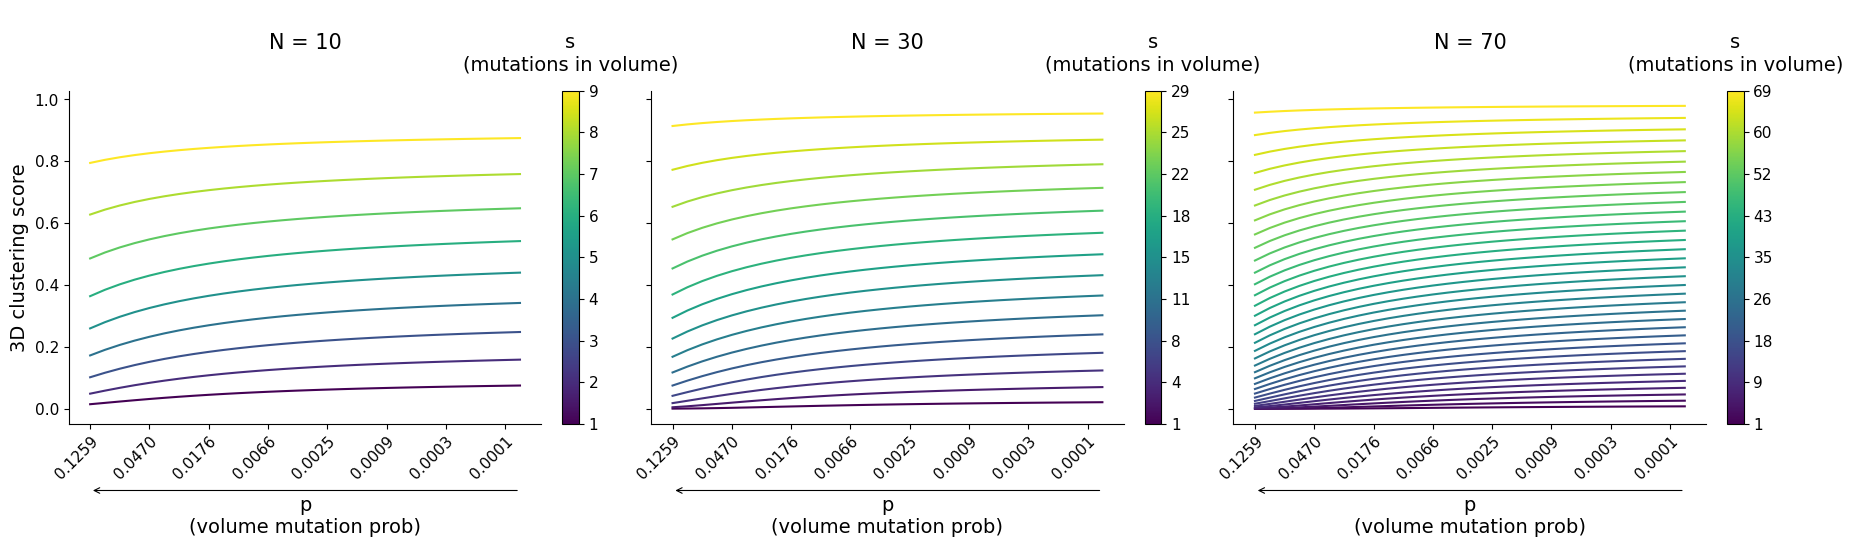

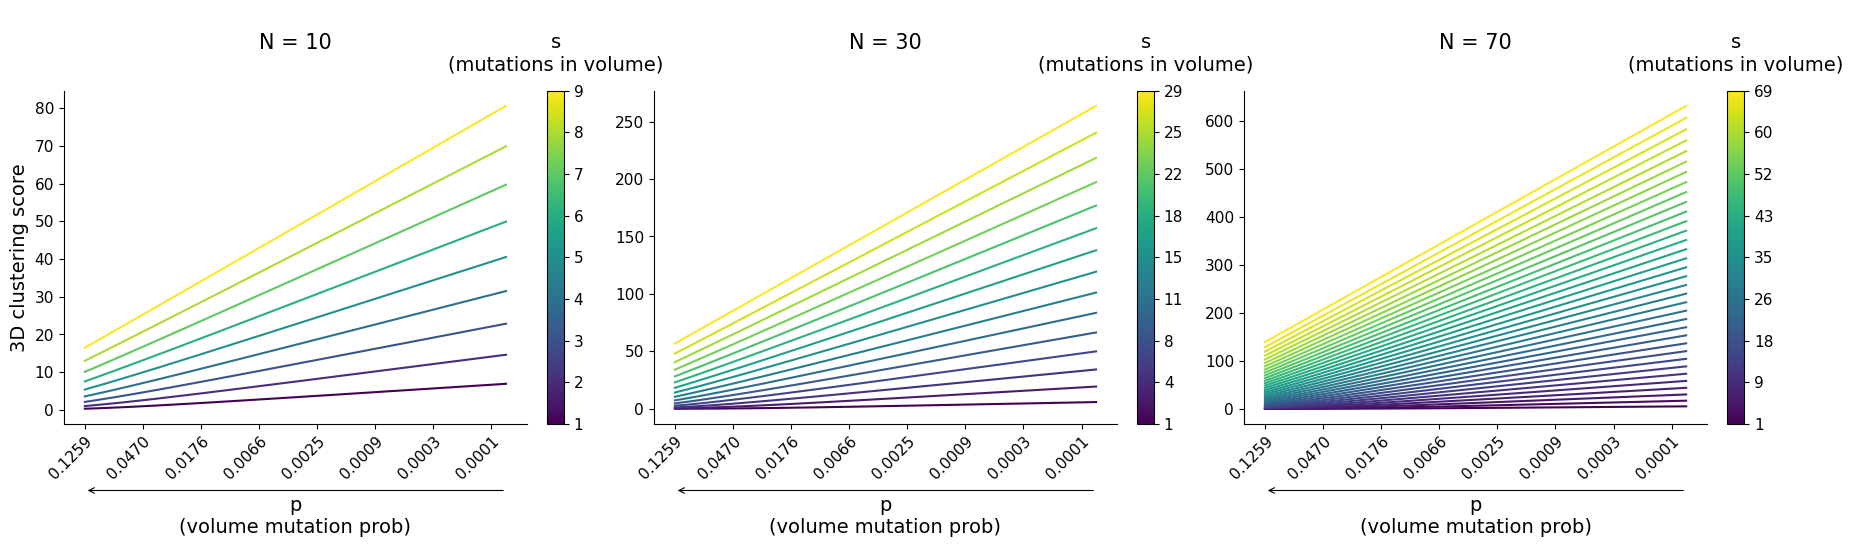

In [77]:
plot_score_function(norm=True)
plot_score_function(norm=False)

## S6, S5, S3: Number of genes and clusters identified using the uncorrected and corrected 3D clustering score

In [78]:
def get_all_o3d_res_result(cohort_df, o3d_output_dir):

    lst_df = []

    for cohort in cohort_df["COHORT"].values:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_pos.csv"
        if os.path.exists(path_csv):
            df_o3d = pd.read_csv(path_csv, low_memory=False)
            cols = ["Cohort", "Gene", "Pos", "Mut_in_gene", "Mut_in_vol", "Score", "Score_obs_sim", "Rank", "pval", 'C', 'C_ext']
            df_o3d = df_o3d[cols].dropna(subset=["pval"]).reset_index(drop=True)
            df_o3d.pval = df_o3d.pval.replace(0, 0.00001)
            lst_df.append(df_o3d)
        # else:
        #     print(f"Path doesn't exist: {path_csv}")
            
    df = pd.concat(lst_df).reset_index(drop=True)

    return df


def get_all_o3d_gene_result(cohort_df, o3d_output_dir):

    lst_df = []
    for cohort in cohort_df["COHORT"].values:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_genes.csv"
        if os.path.exists(path_csv):
            df_o3d = pd.read_csv(path_csv, low_memory=False)
            df_o3d = df_o3d[["Gene", "Uniprot_ID", "Cohort", "pval", "qval", "Score_obs_sim_top_vol", "Mut_in_top_vol", "Mut_in_gene", 'C_gene', 'C_pos']].dropna(subset=["pval"]).reset_index(drop=True)
            df_o3d.pval = df_o3d.pval.replace(0, 0.00001)
            lst_df.append(df_o3d)
        # else:
        #     print(f"Path doesn't exist: {path_csv}")
            
    df = pd.concat(lst_df)

    return df.reset_index(drop=True)

In [79]:
SUBDIR = "review"
datasets = f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/"
output_path = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}"
input_path = f"{datasets}/input/cancer_202404"
cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
cohort_df = cohort_df[~cohort_df.COHORT.str.startswith("ICGC")].reset_index(drop=True)

o3d_path = f"{output_path}/run_control_2025-03-21_11-24-24"
o3d_path_notnorm = f"{output_path}/run_notnorm_2025-03-26_10-58-45"
gene_result = get_all_o3d_gene_result(cohort_df, o3d_path)
res_result = get_all_o3d_res_result(cohort_df, o3d_path)
gene_result_notnorm = get_all_o3d_gene_result(cohort_df, o3d_path_notnorm)
res_result_notnorm = get_all_o3d_res_result(cohort_df, o3d_path_notnorm)

In [80]:
print("Significant gene-cohort p-values:")
print("Norm", len(gene_result[gene_result["pval"] < 0.01]))
print("Not norm", len(gene_result_notnorm[gene_result_notnorm["pval"] < 0.01]))

print("\nSignificant gene-cohort q-values:")
print("Norm", len(gene_result[gene_result["qval"] < 0.01]))
print("Not norm", len(gene_result_notnorm[gene_result_notnorm["qval"] < 0.01]))

print("\nSignificant clusters-cohort p-values:")
print("Norm", len(res_result[res_result["pval"] < 0.01]))
print("Not norm", len(res_result_notnorm[res_result_notnorm["pval"] < 0.01]))

Significant gene-cohort p-values:
Norm 2105
Not norm 3032

Significant gene-cohort q-values:
Norm 619
Not norm 740

Significant clusters-cohort p-values:
Norm 5872
Not norm 7180


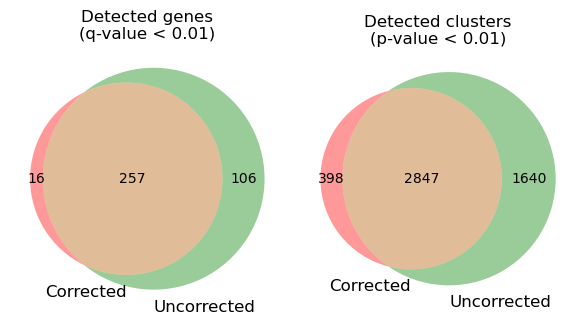

In [82]:
from matplotlib_venn import venn2

# Prepare sets

# Genes (qval)
set1_genes_qval = set(gene_result[gene_result["qval"] < 0.01].Gene)
set2_genes_qval = set(gene_result_notnorm[gene_result_notnorm["qval"] < 0.01].Gene)

# Clusters (pval)
set1_clusters = set(res_result[res_result["pval"] < 0.01][["Gene", "Pos"]]
                    .astype(str).agg(" | ".join, axis=1))
set2_clusters = set(res_result_notnorm[res_result_notnorm["pval"] < 0.01][["Gene", "Pos"]]
                    .astype(str).agg(" | ".join, axis=1))
fig, axes = plt.subplots(1, 2, figsize=(6, 5))

# Venn diagrams
venn2([set1_genes_qval, set2_genes_qval], set_labels=('Corrected', 'Uncorrected'), ax=axes[0])
axes[0].set_title("Detected genes\n(q-value < 0.01)")

venn2([set1_clusters, set2_clusters], set_labels=('Corrected', 'Uncorrected'), ax=axes[1])
axes[1].set_title("Detected clusters\n(p-value < 0.01)")

plt.tight_layout()
plt.show()


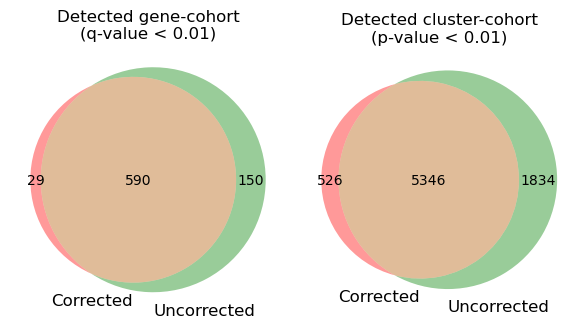

In [99]:
from matplotlib_venn import venn2

# Prepare sets

# Genes (qval)
set1_genes_qval = set(gene_result[gene_result["qval"] < 0.01][["Gene", "Cohort"]]
                    .astype(str).agg(" | ".join, axis=1))
set2_genes_qval = set(gene_result_notnorm[gene_result_notnorm["qval"] < 0.01][["Gene", "Cohort"]]
                    .astype(str).agg(" | ".join, axis=1))

# Clusters (pval)
set1_clusters = set(res_result[res_result["pval"] < 0.01][["Gene", "Pos", "Cohort"]]
                    .astype(str).agg(" | ".join, axis=1))
set2_clusters = set(res_result_notnorm[res_result_notnorm["pval"] < 0.01][["Gene", "Pos", "Cohort"]]
                    .astype(str).agg(" | ".join, axis=1))
fig, axes = plt.subplots(1, 2, figsize=(6, 5))

# Venn diagrams
venn2([set1_genes_qval, set2_genes_qval], set_labels=('Corrected', 'Uncorrected'), ax=axes[0])
axes[0].set_title("Detected gene-cohort\n(q-value < 0.01)")

venn2([set1_clusters, set2_clusters], set_labels=('Corrected', 'Uncorrected'), ax=axes[1])
axes[1].set_title("Detected cluster-cohort\n(p-value < 0.01)")

plt.tight_layout()
plt.show()


In [105]:
# Overlap
union_genes_qval = set1_genes_qval.intersection(set2_genes_qval)
union_list = sorted(union_genes_qval)

# Unique to each set
unique_to_set1 = set1_genes_qval - set2_genes_qval
unique_to_set2 = set2_genes_qval - set1_genes_qval
unique_to_set1 = sorted(unique_to_set1)
unique_to_set2 = sorted(unique_to_set2)

set_genes_overlap = [pair.split(" | ")[0] for pair in union_list]
set_genes_overlap_cgc = [gene for gene in set_genes_overlap if gene in cgc_df.Gene.values]
set1_genes_unique = [pair.split(" | ")[0] for pair in unique_to_set1]
set2_genes_unique = [pair.split(" | ")[0] for pair in unique_to_set2]
set1_genes_unique_cgc = [gene for gene in set1_genes_unique if gene in cgc_df.Gene.values]
set2_genes_unique_cgc = [gene for gene in set2_genes_unique if gene in cgc_df.Gene.values]

print("Total gene-cohort both scores:", len(union_genes_qval))
print(f"Gene-cohort both scores in CGC: {len(set_genes_overlap_cgc)} ({np.round(len(set_genes_overlap_cgc) / len(set_genes_overlap), 2) * 100}%)")
print("\nTotal gene-cohort corrected:", len(set1_genes_unique))
print("Total gene-cohort not corrected:", len(set2_genes_unique))
print(f"Gene-cohort corrected in CGC: {len(set1_genes_unique_cgc)} ({np.round(len(set1_genes_unique_cgc) / len(set1_genes_unique), 2) * 100}%)")
print(f"Gene-cohort not corrected in CGC: {len(set2_genes_unique_cgc)} ({np.round(len(set2_genes_unique_cgc) / len(set2_genes_unique), 2) * 100}%)")

Total gene-cohort both scores: 590
Gene-cohort both scores in CGC: 411 (70.0%)

Total gene-cohort corrected: 29
Total gene-cohort not corrected: 150
Gene-cohort corrected in CGC: 18 (62.0%)
Gene-cohort not corrected in CGC: 51 (34.0%)


In [81]:
gene_result_hits_q = gene_result[gene_result["qval"] < 0.01]
gene_result_notnorm_hits_q = gene_result_notnorm[gene_result_notnorm["qval"] < 0.01]

gene_result_hits_p = gene_result[gene_result["pval"] < 0.01]
gene_result_notnorm_hits_p = gene_result_notnorm[gene_result_notnorm["pval"] < 0.01]

gene_result_ex_q = gene_result_hits_q[~gene_result_hits_q.Gene.isin(gene_result_notnorm_hits_q.Gene)].reset_index(drop=True)
gene_result_notnorm_ex_q = gene_result_notnorm_hits_q[~gene_result_notnorm_hits_q.Gene.isin(gene_result_hits_q.Gene)].reset_index(drop=True)

gene_result_ex_p = gene_result_hits_p[~gene_result_hits_p.Gene.isin(gene_result_notnorm_hits_p.Gene)].reset_index(drop=True)
gene_result_notnorm_ex_p = gene_result_notnorm_hits_p[~gene_result_notnorm_hits_p.Gene.isin(gene_result_hits_p.Gene)].reset_index(drop=True)

In [ ]:
def print_cgc_ratio(df, df_norm, cgc_df):

    norm_count = len(df[df.Gene.isin(cgc_df.Gene.values)].Gene)
    not_norm_count = len(df_norm[df_norm.Gene.isin(cgc_df.Gene.values)].Gene)

    print(f"CGC ratio Norm ({len(df)}):     {norm_count / len(df):.3} ({norm_count})")
    print(f"CGC ratio Not Norm ({len(df_norm)}): {not_norm_count / len(df_norm):.3} ({not_norm_count})")

print("\n> Hits qval < 0.01") 
print_cgc_ratio(gene_result_hits_q, gene_result_notnorm_hits_q, cgc_df)

print("\n> Exclusive Hits qval < 0.01") 
print_cgc_ratio(gene_result_ex_q, gene_result_notnorm_ex_q, cgc_df)

print("\n\n> Hits pval < 0.01") 
print_cgc_ratio(gene_result_hits_p, gene_result_notnorm_hits_p, cgc_df)

print("\n> Exclusive Hits pval < 0.01") 
print_cgc_ratio(gene_result_ex_p, gene_result_notnorm_ex_p, cgc_df)

In [29]:
def print_cgc_ratio(df, df_norm, cgc_df):

    norm_count = len(df[df.Gene.isin(cgc_df.Gene.values)].Gene)
    not_norm_count = len(df_norm[df_norm.Gene.isin(cgc_df.Gene.values)].Gene)

    print(f"CGC ratio Norm ({len(df)}):     {norm_count / len(df):.3} ({norm_count})")
    print(f"CGC ratio Not Norm ({len(df_norm)}): {not_norm_count / len(df_norm):.3} ({not_norm_count})")

print("\n> Hits qval < 0.01") 
print_cgc_ratio(gene_result_hits_q, gene_result_notnorm_hits_q, cgc_df)

print("\n> Exclusive Hits qval < 0.01") 
print_cgc_ratio(gene_result_ex_q, gene_result_notnorm_ex_q, cgc_df)

print("\n\n> Hits pval < 0.01") 
print_cgc_ratio(gene_result_hits_p, gene_result_notnorm_hits_p, cgc_df)

print("\n> Exclusive Hits pval < 0.01") 
print_cgc_ratio(gene_result_ex_p, gene_result_notnorm_ex_p, cgc_df)


> Hits qval < 0.01
CGC ratio Norm (619):     0.693 (429)
CGC ratio Not Norm (740): 0.624 (462)

> Exclusive Hits qval < 0.01
CGC ratio Norm (16):     0.438 (7)
CGC ratio Not Norm (109): 0.174 (19)


> Hits pval < 0.01
CGC ratio Norm (2105):     0.376 (791)
CGC ratio Not Norm (3032): 0.278 (842)

> Exclusive Hits pval < 0.01
CGC ratio Norm (167):     0.102 (17)
CGC ratio Not Norm (946): 0.0465 (44)


In [30]:
gene_result_un_q = gene_result_hits_q[gene_result_hits_q.Gene.isin(gene_result_notnorm_hits_q.Gene)].reset_index(drop=True)
len(gene_result_un_q.Gene.unique())

257

,Mut_in_top_vol,Count
0,3.0,81
1,4.0,59
2,5.0,16
3,8.0,4
4,6.0,3
5,9.0,2
6,11.0,1
7,7.0,1


,Mut_in_top_vol,Count
0,2.0,671
1,3.0,209
2,4.0,45
3,5.0,11
4,6.0,5
5,7.0,4
6,9.0,1


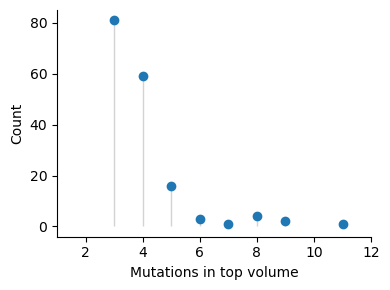

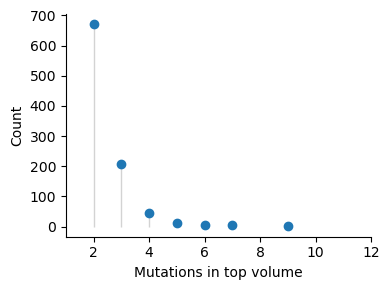

In [31]:
# Hits
display(gene_result_ex_p.Mut_in_top_vol.value_counts().reset_index().rename(
    columns={"Mut_in_top_vol": "Count", "index": "Mut_in_top_vol"}))
display(gene_result_notnorm_ex_p.Mut_in_top_vol.value_counts().reset_index().rename(
    columns={"Mut_in_top_vol": "Count", "index": "Mut_in_top_vol"}))

# Corrected score
hits_norm = gene_result_ex_p.Mut_in_top_vol.value_counts().reset_index().rename(
    columns={"Mut_in_top_vol": "Count", "index": "Mut_in_top_vol"})

plt.figure(figsize=(4, 3))
plt.vlines(x=hits_norm["Mut_in_top_vol"], ymin=0, ymax=hits_norm["Count"], color='lightgray', linewidth=1, zorder=1)
plt.scatter(hits_norm["Mut_in_top_vol"], hits_norm["Count"], zorder=2)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim(1, 12)
plt.xlabel("Mutations in top volume")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# Uncorrected score hits
hits_notnorm = gene_result_notnorm_ex_p.Mut_in_top_vol.value_counts().reset_index().rename(
    columns={"Mut_in_top_vol": "Count", "index": "Mut_in_top_vol"})

plt.figure(figsize=(4, 3))
plt.vlines(x=hits_notnorm["Mut_in_top_vol"], ymin=0, ymax=hits_notnorm["Count"], color='lightgray', linewidth=1, zorder=1)
plt.scatter(hits_notnorm["Mut_in_top_vol"], hits_notnorm["Count"], zorder=2)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim(1, 12)
plt.xlabel("Mutations in top volume")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


,Mut_in_top_vol,Count
0,5.0,7
1,4.0,5
2,6.0,2
3,17.0,1
4,7.0,1


,Mut_in_top_vol,Count
0,4.0,37
1,3.0,24
2,5.0,20
3,6.0,12
4,8.0,6
5,7.0,5
6,2.0,4
7,10.0,1


/home/bbg/spellegrini/miniconda3/envs/o3d_nb/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


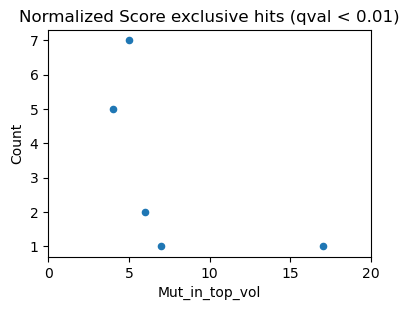

/home/bbg/spellegrini/miniconda3/envs/o3d_nb/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


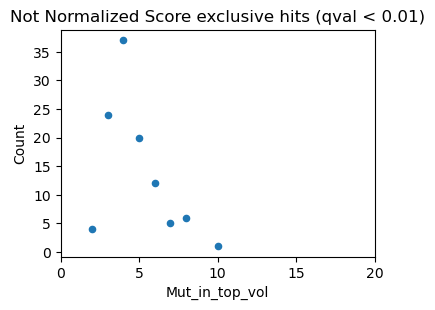

In [32]:
# Exclusive hits
gene_result_ex_q_notcgc = gene_result_ex_q[~gene_result_ex_q.Gene.isin(cgc_df.Gene.values)]
gene_result_notnorm_ex_q_notcgc = gene_result_notnorm_ex_q[~gene_result_notnorm_ex_q.Gene.isin(cgc_df.Gene.values)]

display(gene_result_ex_q.Mut_in_top_vol.value_counts().reset_index().rename(
    columns={"Mut_in_top_vol": "Count", "index": "Mut_in_top_vol"}))
display(gene_result_notnorm_ex_q.Mut_in_top_vol.value_counts().reset_index().rename(
    columns={"Mut_in_top_vol": "Count", "index": "Mut_in_top_vol"}))

plt.figure(figsize=(4, 3))
gene_result_ex_q.Mut_in_top_vol.value_counts().reset_index().rename(
    columns={"Mut_in_top_vol": "Count", "index": "Mut_in_top_vol"}).plot.scatter(x="Mut_in_top_vol", y="Count", ax=plt.gca())
plt.xlim(0, 20)
plt.tight_layout()
plt.title("Normalized Score exclusive hits (qval < 0.01)")
plt.show()

plt.figure(figsize=(4, 3))
gene_result_notnorm_ex_q.Mut_in_top_vol.value_counts().reset_index().rename(
    columns={"Mut_in_top_vol": "Count", "index": "Mut_in_top_vol"}).plot.scatter(x="Mut_in_top_vol", y="Count", ax=plt.gca())
plt.xlim(0, 20)
plt.tight_layout()
plt.title("Not Normalized Score exclusive hits (qval < 0.01)")
plt.show()

,Mut_in_top_vol,Count
0,5.0,7
1,4.0,5
2,6.0,2
3,17.0,1
4,7.0,1


,Mut_in_top_vol,Count
0,4.0,37
1,3.0,24
2,5.0,20
3,6.0,12
4,8.0,6
5,7.0,5
6,2.0,4
7,10.0,1


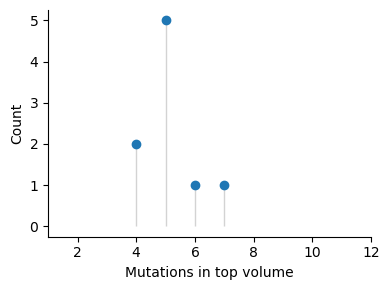

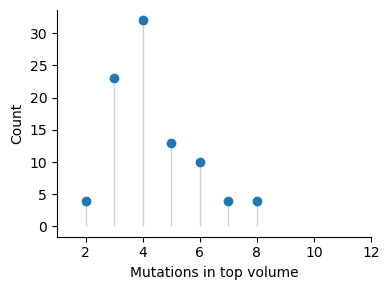

In [33]:
# Exclusive hits
gene_result_ex_q_notcgc = gene_result_ex_q[~gene_result_ex_q.Gene.isin(cgc_df.Gene.values)]
gene_result_notnorm_ex_q_notcgc = gene_result_notnorm_ex_q[~gene_result_notnorm_ex_q.Gene.isin(cgc_df.Gene.values)]

display(gene_result_ex_q.Mut_in_top_vol.value_counts().reset_index().rename(
    columns={"Mut_in_top_vol": "Count", "index": "Mut_in_top_vol"}))
display(gene_result_notnorm_ex_q.Mut_in_top_vol.value_counts().reset_index().rename(
    columns={"Mut_in_top_vol": "Count", "index": "Mut_in_top_vol"}))

# Corrected score
hits_norm = gene_result_ex_q_notcgc.Mut_in_top_vol.value_counts().reset_index().rename(
    columns={"Mut_in_top_vol": "Count", "index": "Mut_in_top_vol"})

plt.figure(figsize=(4, 3))
plt.vlines(x=hits_norm["Mut_in_top_vol"], ymin=0, ymax=hits_norm["Count"], color='lightgray', linewidth=1, zorder=1)
plt.scatter(hits_norm["Mut_in_top_vol"], hits_norm["Count"], zorder=2)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim(1, 12)
plt.xlabel("Mutations in top volume")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# Uncorrected score hits
hits_notnorm = gene_result_notnorm_ex_q_notcgc.Mut_in_top_vol.value_counts().reset_index().rename(
    columns={"Mut_in_top_vol": "Count", "index": "Mut_in_top_vol"})

plt.figure(figsize=(4, 3))
plt.vlines(x=hits_notnorm["Mut_in_top_vol"], ymin=0, ymax=hits_notnorm["Count"], color='lightgray', linewidth=1, zorder=1)
plt.scatter(hits_notnorm["Mut_in_top_vol"], hits_notnorm["Count"], zorder=2)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim(1, 12)
plt.xlabel("Mutations in top volume")
plt.ylabel("Count")
plt.tight_layout()
plt.show()